This report contains, in addition to the code provided by the lecturer, my own code changes
and additions, and written answers to answer coursework 9 in Machine Learning and Statistics.

In [1]:
# Load the libraries needed
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import time

# Seed random number generator
np.random.seed(123)

# Helper functions for polynomials
def powers( X, n ):
    """ Returns an array of the powers of the elements of X up to the nth power """
    return np.power(np.expand_dims(X, axis=-1), [np.arange(n)])

def polynomial( X, poly_coeff ):
    """ Returns the value of a polynomial at x with given coefficients """
    deg = np.shape(poly_coeff)[-1]
    return np.dot(powers(X, deg), np.transpose(poly_coeff), )

def fit_polynomial( X, y, n ):
    """ Returns the coefficients of the n-degree polynomial fit to (X, y) """
    X_pwrs = powers(X, n+1)
    # Do linear least squares fit
    coeff, _, _, _ = np.linalg.lstsq(X_pwrs, y, rcond=None)
    return coeff

def degree( poly_coeff ):
    """ Returns the degree of a polynomial from its coefficients """
    return len(poly_coeff)-1

In [2]:
# RSS, AIC, and BIC scores
# You should modify the functions aic_loss and bic_loss to compute
# the AIC, and BIC, penalties given a dataset X, y, and learned
# polynomial model with coefficients learned_coeff.

def rss_loss(X, y, learned_coeff):
    """ Computes the residual sum of squares loss for a given polynomial on 
    the given data """
    pred_y = polynomial(X, learned_coeff)
    return np.sum(np.square(pred_y - y))
    
def aic_loss(X, y, learned_coeff):
    """ Computes the Akaike’s Information Criterion for a given polynomial on 
    the given data """
    # You will need to modify this function to return the correct result
    RSS = rss_loss(X,y,learned_coeff) 
    aic = (1/len(X))*(RSS+2*len(learned_coeff))
    return aic
    
def bic_loss(X, y, learned_coeff):
    """ Computes the Bayesian Information Criterion for a given polynomial on 
    the given data """
    # You will need to modify this function to return the correct result
    RSS = rss_loss(X,y,learned_coeff) 
    bic = (1/len(X))*(RSS+len(learned_coeff)*np.log(len(X)))
    return bic

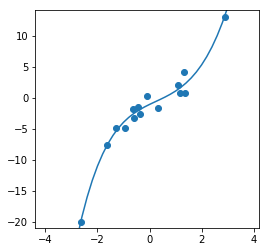

Fitted a degree 5 polynomial with RSS loss: 15.34, AIC loss: 1.82, BIC loss: 2.11 to 15 datapoints.
[-1.09065806  2.02523857 -0.33298202  0.48379912 -0.02799822  0.00711476]


In [3]:
# Using AIC/BIC to compare models
# You should see how the AIC and BIC scores compare for different
# models by changing the model degree (given by the variable n).

# Load data
X, y = np.load("./class9_generated_data.npy")

#Plot the data
plt.figure(figsize=(4,4))
plt.scatter(X,y)
plt.ylim(y.min()-1., y.max()+1.)

# Make sequence of x-values for plotting
axis_X = np.arange(-4.0, 4.0, 0.2)

# Fit a polynomial
n = 5
learned_coefficients = fit_polynomial( X, y, n )

#Plot the learned polynomial
poly_y = polynomial(axis_X, learned_coefficients)
plt.plot(axis_X, poly_y, )

plt.show()

num_points = np.shape(X)[0]
rss = rss_loss(X, y, learned_coefficients)
aic = aic_loss(X, y, learned_coefficients)
bic = bic_loss(X, y, learned_coefficients)
str_ = "Fitted a degree {:d} polynomial with ".format(degree(learned_coefficients))
str_ += "RSS loss: {:.2f}, AIC loss: {:.2f}, BIC loss: {:.2f} ".format(rss, aic, bic)
print(str_ + "to {:d} datapoints.".format(num_points))

print(learned_coefficients)

# Assignment 1:

Complete the functions aic_loss and bic_loss for calculating the AIC and the
BIC scores for a learned or trained polynomial model. In your implementation, you can use the
provided function to calculate the degree of a given polynomial model. Run the code and record
the RSS, AIC, and BIC scores on the given data set. Repeat this for polynomial models of degrees 1, 3,
and 5. Report all the scores for polynomial models of different degrees. With the results achieved,
comment on which polynomial degree has been used to generate the data set. <br>
Answer: <br>

The completed functions for AIC and BIC loss can be found in the code above. Report for polynomial models of different degrees: <br>

 - Degree 1 polynomial (n = 1): Fitted a degree 1 polynomial with RSS loss: 100.73, AIC loss: 6.98, BIC loss: 7.08 to 15 datapoints. <br>

 - Degree 3 polynomial (n = 3): Fitted a degree 3 polynomial with RSS loss: 15.57, AIC loss: 1.57, BIC loss: 1.76 to 15 datapoints. <br>

 - Degree 5 polynomial (n = 5): Fitted a degree 5 polynomial with RSS loss: 15.34, AIC loss: 1.82, BIC loss: 2.11 to 15 datapoints. <br>

We can see that the polynomial of degree 3 gives the smallest values of BIC and AIC loss, thus degree 3 is the degree with which the polynomial was generated. Tested with n = 2 and n = 4 as well just to be sure that these were not better. <br> 

In [4]:
# Helper functions for linear models
def linear ( X, coefficients ):
    return np.dot(X, np.transpose(coefficients), )

def fit_linear( X, y, features=None ):
    """ 
        Returns the coefficients of a linear model fit to X,y.
        If features is a list of integers, then fit will ignore
        any features whose index is not in the list.
        ( Returned coefficients for these features will be set
        to 0. )
    """
    if features is not None:
        # Make a mask
        tot_num_features = np.shape(X)[-1]
        mask = np.zeros((1,tot_num_features))
        mask[0,features] = 1.
        # Zero out all irrellevant features
        X = X * mask
    
    # Do linear least squares fit
    coeff, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    return coeff

In [5]:
# AIC and BIC for feature selection
# The following is an implementation of forward feature selection.
# However, as a criterion it uses the Mean Square Error (MSE) score
# ( = RSS / num_examples). This is largely useless as adding more
# features will always give a lower MSE score.
# You should modify the code below by calculating the AIC penalty for
# the learned linear model each iteration and setting the score variable
# to this value.

# Load data
data = []
continuous_features = [ 0, 1, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24, 25 ]

# Original data is from https://archive.ics.uci.edu/ml/datasets/automobile
with open('./automobile.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='\"')
    for row in csvreader:
        try:
            # Get all continuous rows
            data.append([float(row[i]) for i in continuous_features])
        except:
            continue # skip this row since data-processing failed

data = np.array(data)
y = data[:, 0] # target is first value
X = data[:, 1:] # training data is the rest

# Normalize the data to zero mean and unit std
X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, keepdims=True)
y = (y - np.mean(y)) / np.std(y)

print("Successfully loaded {:d} entries.\n".format(len(X)))
    

# Forwards stepwise feature selection
tot_num_features = np.shape(X)[-1]
all_features = range(tot_num_features)
curr_features = []

best_score = 1e9
best_features = None

print("Performing forwards stepwise feature selection using AIC as criteria...")
# While we have remaining features...
while len(curr_features) != tot_num_features:
    # Get remaining features 
    candidate_features = [ f for f in all_features if f not in curr_features ]
    
    best_score_this_round = 1e9
    best_feature_this_round = None
    for f in candidate_features:
        test_features = curr_features + [f]
        learned_coefficients = fit_linear( X, y, test_features )
        
        y_pred = linear(X, learned_coefficients)
        RSS_loss = np.sum(np.square(y_pred - y))
        AIC_loss = (1/len(X))*(RSS_loss+(2*(len(test_features)+1)))
        score = AIC_loss
        
        # Remember, lower score is better
        if score < best_score_this_round:
            best_score_this_round = score
            best_feature_this_round = f
            
        if score < best_score:
            best_score = score
            best_features = test_features
            
    # Set current features to best features from round
    curr_features = curr_features + [best_feature_this_round]
    print("Round {}, selected feature {:d} with score {:.3f}".format(len(curr_features), 
                                    best_feature_this_round, best_score_this_round ))
            
print("Best features were {} ({:d} total) with score {:.3f}".format(best_features, 
                                                len(best_features), best_score))

Successfully loaded 160 entries.

Performing forwards stepwise feature selection using AIC as criteria...
Round 1, selected feature 1 with score 0.754
Round 2, selected feature 0 with score 0.530
Round 3, selected feature 3 with score 0.490
Round 4, selected feature 2 with score 0.498
Round 5, selected feature 9 with score 0.506
Round 6, selected feature 12 with score 0.516
Round 7, selected feature 13 with score 0.517
Round 8, selected feature 4 with score 0.528
Round 9, selected feature 10 with score 0.539
Round 10, selected feature 5 with score 0.550
Round 11, selected feature 11 with score 0.560
Round 12, selected feature 6 with score 0.572
Round 13, selected feature 7 with score 0.584
Round 14, selected feature 14 with score 0.596
Round 15, selected feature 8 with score 0.608
Best features were [1, 0, 3] (3 total) with score 0.490


# Assignment 2

 Modify the provided forward feature selection routine to use the AIC score instead
of the RSS as its evaluation criterion. Run your modified code on the Automobile data set to select
a best feature subset for the insurance category prediction of a vehicle. <br>

Answer: <br>

See modified code above. The best feature subet, as the output above suggests, is 1 , 0 og 3, with an AIC score of 0.490.

In [6]:
# Backwards feature selection
# Copy the code above and modify it to implement backwards feature
# selection using the AIC criterion as a scoring function.

# Load data
data = []
continuous_features = [ 0, 1, 9, 10, 11, 12, 13, 
                       16, 18, 19, 20, 21, 22, 23, 24, 25 ]

# Original data is from https://archive.ics.uci.edu/ml/datasets/automobile
with open('./automobile.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='\"')
    for row in csvreader:
        try:
            # Get all continuous rows
            data.append([float(row[i]) for i in continuous_features])
        except:
            continue # skip this row since data-processing failed

data = np.array(data)
y = data[:, 0] # target is first value
X = data[:, 1:] # training data is the rest

# Normalize the data to zero mean and unit std
X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, 
                                                     keepdims=True)
y = (y - np.mean(y)) / np.std(y)

print("Successfully loaded {:d} entries.\n".format(len(X)))
    
#Backward stepwise feature selection

#start out by saying that we start out with all the features
tot_num_features = np.shape(X)[-1]
all_features = range(tot_num_features)
curr_features = list(range(tot_num_features))

#calculate the AIC-score for the full model and start out with that
#as the best score and model
learned_coefficients = fit_linear( X, y, curr_features )
y_pred = linear(X, learned_coefficients)
RSS_loss = np.sum(np.square(y_pred - y))
AIC_score_start = (1/len(X))*(RSS_loss+(2*(len(curr_features)+1)))

best_score = AIC_score_start
best_features = curr_features

print("Performing backward stepwise feature selection using AIC as criteria...")
# While we have remaining features...
while len(curr_features) > 0:   
    #need to keep track of the best score and the feature which
    #gave the best result when removed
    best_score_this_round = 1e9
    worst_feature_this_round = None
    
    for f in range(len(curr_features)):  
        #for each loop remove one of the features
        i = curr_features[f]
        test_features = curr_features
        test_features = list(filter(lambda x:x != i,test_features))
        
        #test model without selected feature
        learned_coefficients = fit_linear( X, y, test_features )
        y_pred = linear(X, learned_coefficients)
        RSS_loss = np.sum(np.square(y_pred - y))
        AIC_score = (1/len(X))*(RSS_loss+(2*(len(test_features)+1)))
        
        # Remember, lower score is better
        if AIC_score < best_score_this_round:
            best_score_this_round = AIC_score
            worst_feature_this_round = i
            
        if AIC_score < best_score:
            best_score = AIC_score
            best_features = test_features

    # Set current features to best features from round
    #by removing the "worst" feature from this round
    curr_features = list(filter(lambda x:x != worst_feature_this_round,curr_features))
    print("Round {}, selected feature {:d} to be removed, with score {:.3f}"\
          .format(len(curr_features), worst_feature_this_round, best_score_this_round ))
            
print("Best features were {} ({:d} total) with score {:.3f}".format(best_features, 
                                                    len(best_features), best_score))

Successfully loaded 160 entries.

Performing backward stepwise feature selection using AIC as criteria...
Round 14, selected feature 8 to be removed, with score 0.596
Round 13, selected feature 14 to be removed, with score 0.584
Round 12, selected feature 2 to be removed, with score 0.571
Round 11, selected feature 7 to be removed, with score 0.559
Round 10, selected feature 6 to be removed, with score 0.548
Round 9, selected feature 11 to be removed, with score 0.538
Round 8, selected feature 5 to be removed, with score 0.527
Round 7, selected feature 10 to be removed, with score 0.516
Round 6, selected feature 4 to be removed, with score 0.505
Round 5, selected feature 9 to be removed, with score 0.502
Round 4, selected feature 13 to be removed, with score 0.502
Round 3, selected feature 12 to be removed, with score 0.490
Round 2, selected feature 3 to be removed, with score 0.530
Round 1, selected feature 0 to be removed, with score 0.754
Round 0, selected feature 1 to be removed, w

# Assignment 3

Implement the backward stepwise feature selection routine. Run your backward
selection code on the Automobile data set to select a best feature subset for the insurance category
prediction of a vehicle. Compare the results of running backwards feature selection to running
forwards feature selection. With the results and your justification, comment on whether there is a
difference between two feature selection methods in terms of this data set.<br>

Answer: <br>

See the above code for my implementation of backward feature selection. We see by the output that the backward stepwise feature selections selects the same feature subset as the forward routine. So for this dataset, there is no difference in their conclusion. However, if one looks at the order in which features are added/taken away - there is a difference. Still, the conlusion is the same.